In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import (classification_report,accuracy_score,
                             confusion_matrix, roc_auc_score,
                             roc_curve, auc)

import joblib

# Load Data

In [4]:
data = pd.read_csv(r"C:\Users\USER\AI-Projects\ML Projects\Diabetes Prediction\Original Data\Dataset\diabetes_final.csv")
data.drop('Unnamed: 0', axis=1, inplace=True)
data.head()

,age,physical_activity_minutes_per_week,diet_score,screen_time_hours_per_day,family_history_diabetes,hypertension_history,cardiovascular_history,bmi,waist_to_hip_ratio,systolic_bp,...,ethnicity_Other,ethnicity_White,employment_status_Employed,employment_status_Retired,employment_status_Student,employment_status_Unemployed,smoking_status_Current,smoking_status_Former,smoking_status_Never,diagnosed_diabetes
0,0.504956,1.138363,-0.165523,0.771162,-0.530172,-0.578582,-0.293278,1.362636,0.724256,1.274180,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1
1,-0.135884,0.285376,0.395977,1.095260,-0.530172,-0.578582,-0.293278,-0.700550,-1.197300,0.924138,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
2,0.633124,-0.733470,0.227527,0.852187,1.886181,-0.578582,-0.293278,-0.951478,-0.983794,-0.055979,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1
3,1.530299,-0.828246,-1.456972,-0.322667,-0.530172,-0.578582,-0.293278,0.331043,0.510750,0.294063,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1
4,-0.264052,-0.117424,0.676727,-0.403691,-0.530172,-0.578582,-0.293278,-1.230287,-1.624313,-1.666172,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1


In [5]:
y = data['diagnosed_diabetes']
x = data.drop('diagnosed_diabetes', axis=1)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, shuffle=True)

# 1. LogisticRegression (Baseline)

In [5]:
LR_model = LogisticRegression()
LR_model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


In [6]:
y_pred_lr = LR_model.predict(X_test)

print("Accuracy score = ", accuracy_score(y_test, y_pred_lr))
print("="*50)
print("Classification report = \n",classification_report(y_test, y_pred_lr))

Accuracy score =  0.8571
Classification report = 
               precision    recall  f1-score   support

           0       0.83      0.81      0.82      8077
           1       0.87      0.89      0.88     11923

    accuracy                           0.86     20000
   macro avg       0.85      0.85      0.85     20000
weighted avg       0.86      0.86      0.86     20000



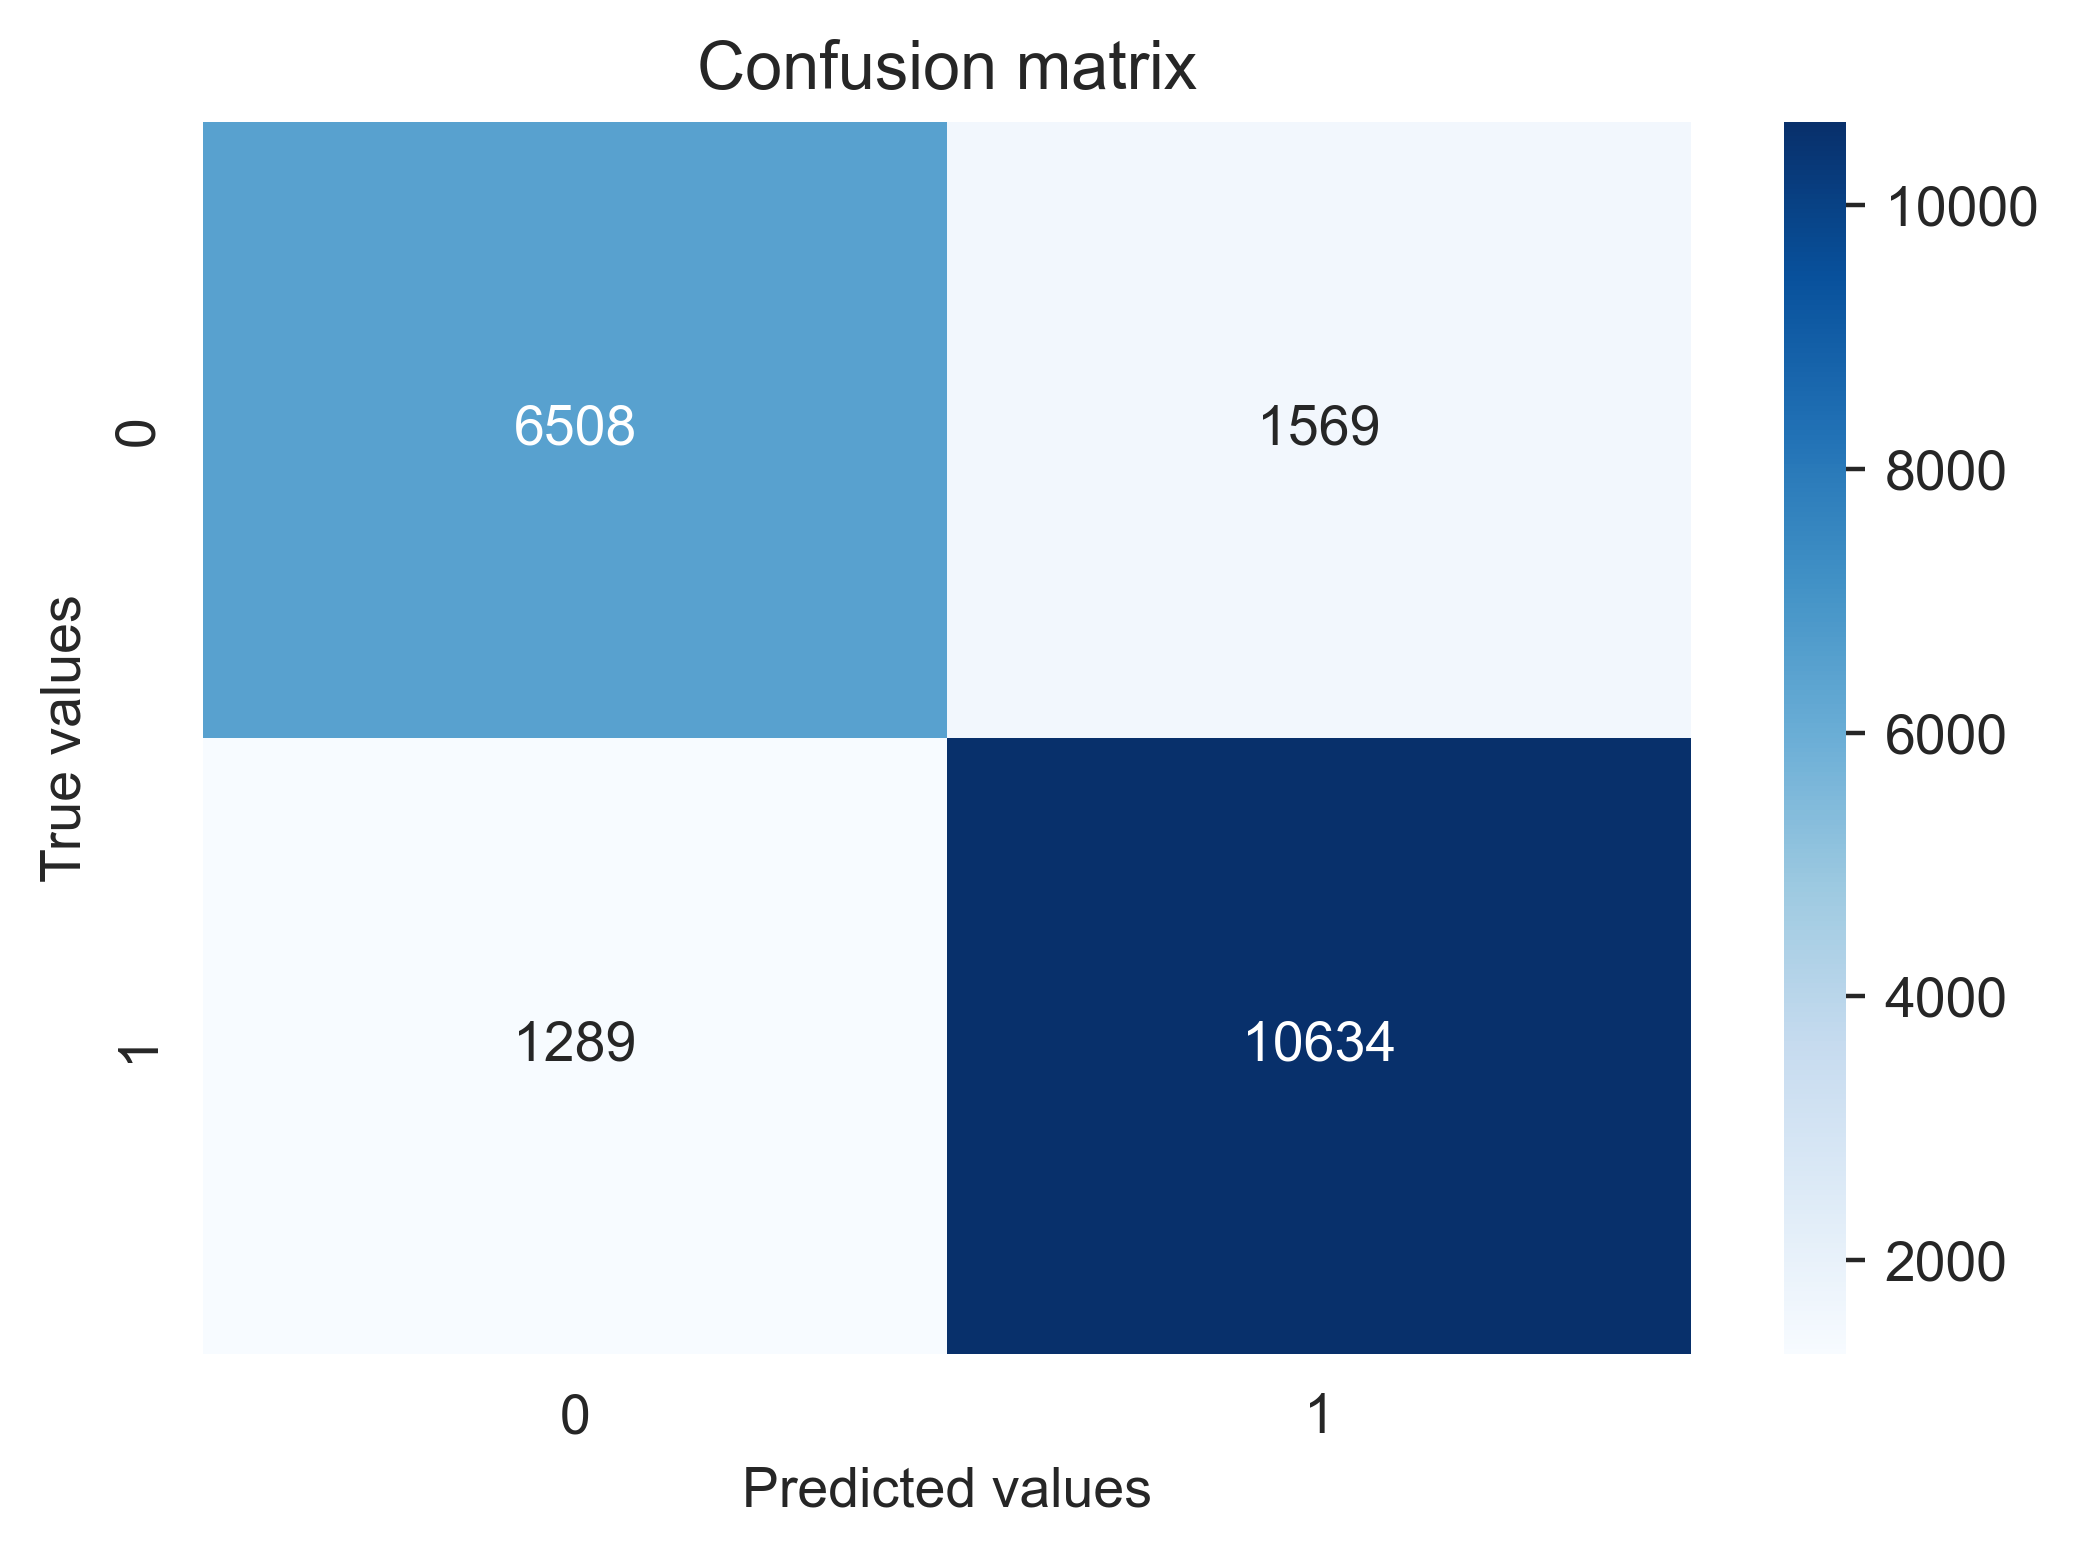

In [7]:
plt.figure(figsize=(6,4) ,dpi=400)
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='g', cmap="Blues")
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.title('Confusion matrix')
plt.show()

In [8]:
lr_probs = LR_model.predict_proba(X_test)[:, 1]
lr_auc = roc_auc_score(y_test, lr_probs)
print(f"LogisticRegression AUC Score: {lr_auc:.4f}")

LogisticRegression AUC Score: 0.9327


In [9]:
lr_probs

array([0.03523485, 0.99654711, 0.31875977, ..., 0.86404227, 0.56464861,
       0.05459238])

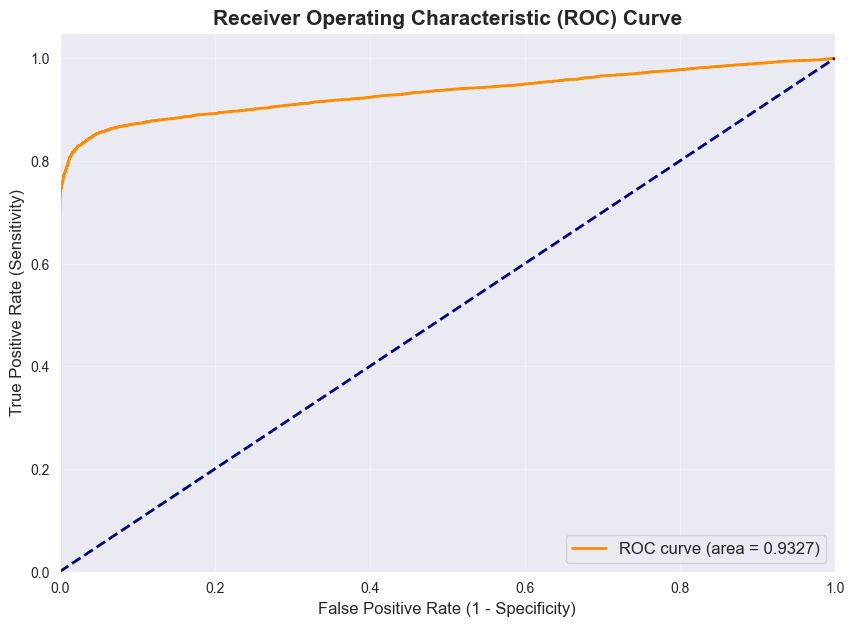

In [10]:
# 1. حساب القيم الخاصة بالكرف (False Positive Rate & True Positive Rate)
fpr, tpr, thresholds = roc_curve(y_test, lr_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 7), dpi=100)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=15, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)

plt.show()

# 2. XGBoost

In [17]:
XGB = XGBClassifier(random_state=42, device='gpu')
param = {
    'n_estimators': [200, 600, 1000],       # عدد الأشجار
    'learning_rate': [0.01, 0.05, 0.1],                # سرعة التعلم
    'max_depth': [4, 6, 8],                           # عمق الشجرة
}

grid = GridSearchCV(XGB, param, cv=5, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)
print("Best Parameters:", grid.best_params_)
print("Best Score:",  grid.best_score_)

KeyboardInterrupt: 

In [7]:
XGB_model = XGBClassifier(n_estimators=200, learning_rate=0.01, max_depth=4, random_state=42)
XGB_model.fit(X_train, y_train)

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [8]:
y_pred_xgb = XGB_model.predict(X_test)

print("Accuracy score = ", accuracy_score(y_test, y_pred_xgb))
print("="*50)
print("Classification report = \n",classification_report(y_test, y_pred_xgb))

Accuracy score =  0.9202
Classification report = 
               precision    recall  f1-score   support

           0       0.84      1.00      0.91      8077
           1       1.00      0.87      0.93     11923

    accuracy                           0.92     20000
   macro avg       0.92      0.93      0.92     20000
weighted avg       0.93      0.92      0.92     20000



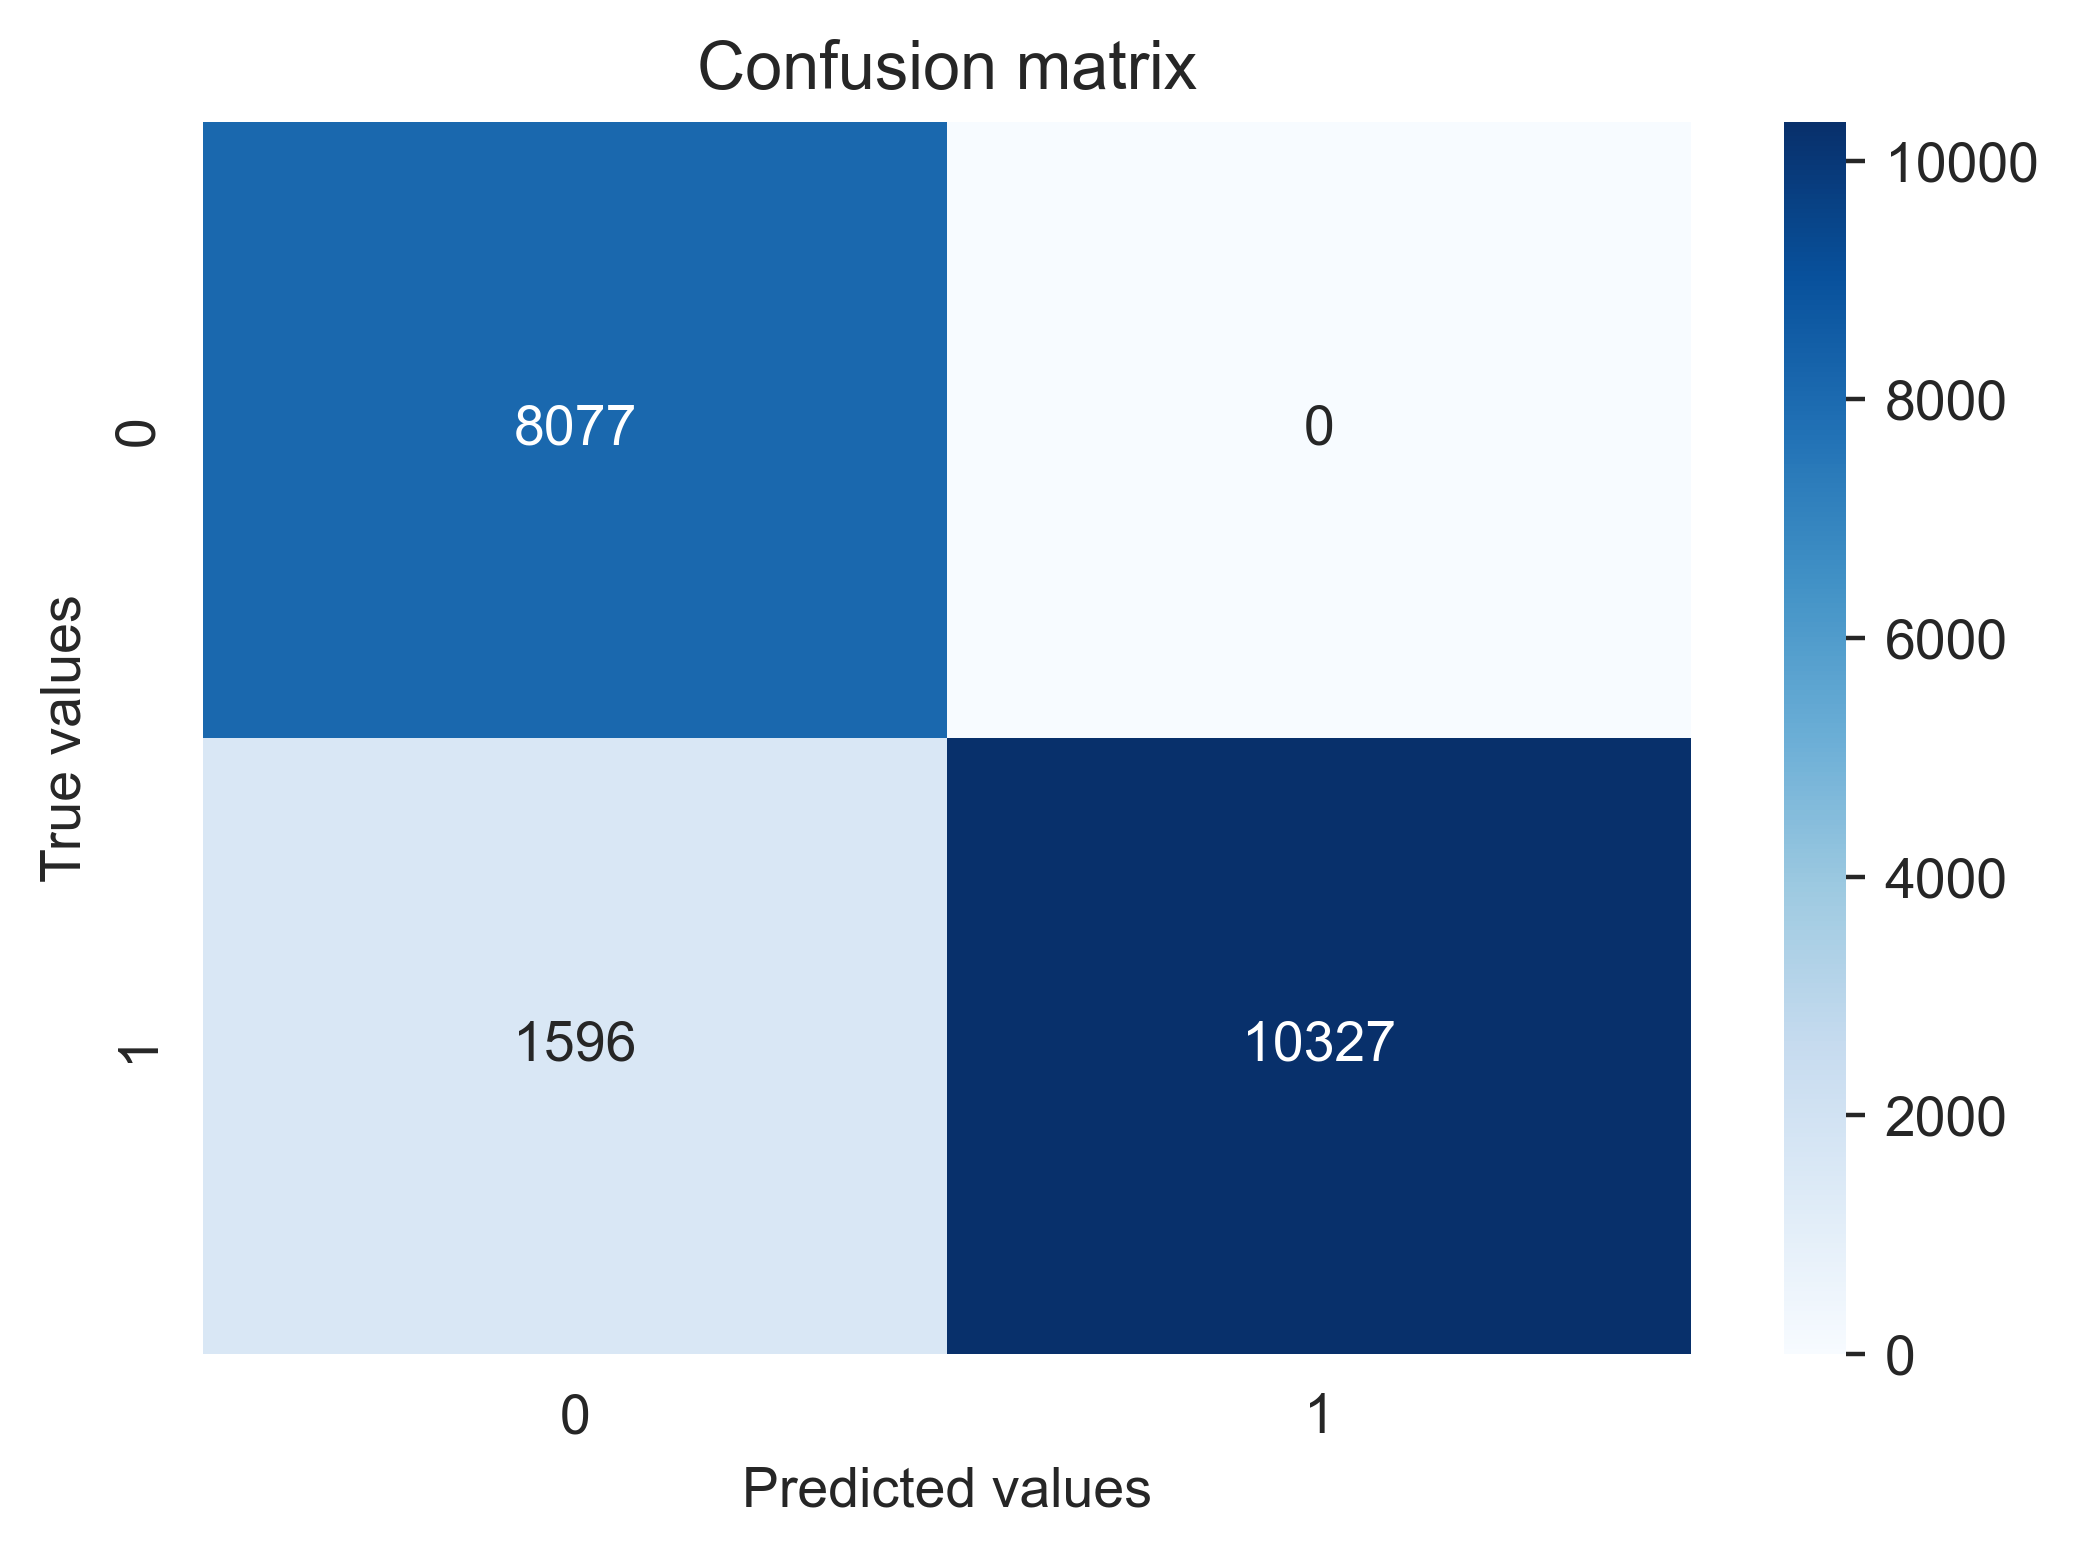

In [9]:
plt.figure(figsize=(6,4) ,dpi=400)
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt='g', cmap="Blues")
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.title('Confusion matrix')
plt.show()

In [21]:
xgb_probs = XGB_model.predict_proba(X_test)[:, 1]
xgb_auc = roc_auc_score(y_test, xgb_probs)
print(f"XGBClassifier AUC Score: {xgb_auc:.4f}")

XGBClassifier AUC Score: 0.9455


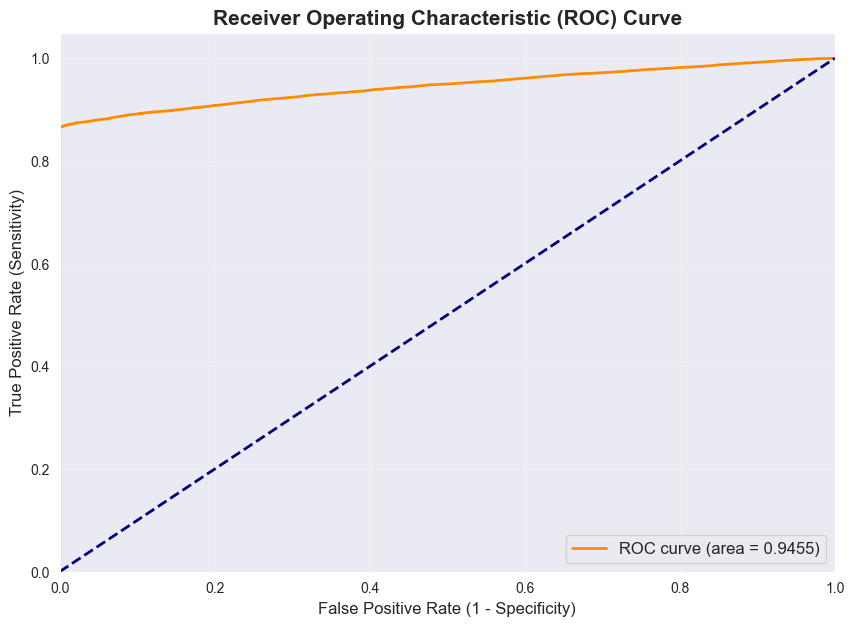

In [22]:
# 1. حساب القيم الخاصة بالكرف (False Positive Rate & True Positive Rate)
fpr, tpr, thresholds = roc_curve(y_test, xgb_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 7), dpi=100)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=15, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)

plt.show()

# 3. LightGBM

In [23]:
LGM = LGBMClassifier(random_state=42, device='gpu')
param = {
    'n_estimators': [200, 600, 1000],       # عدد الأشجار
    'learning_rate': [0.01, 0.05, 0.1],                # سرعة التعلم
    'num_leaves': [11, 21, 31],                           # عمق الشجرة
}

grid = GridSearchCV(LGM, param, cv=5, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)
print("Best Parameters:", grid.best_params_)
print("Best Score:",  grid.best_score_)

KeyboardInterrupt: 

In [11]:
LGBM_model = LGBMClassifier(n_estimators=600, learning_rate=0.01, num_leaves=11, random_state=42, device='gpu')
LGBM_model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 48075, number of negative: 31925
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 2641
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 37
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 3050 Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 23 dense feature groups (1.83 MB) transferred to GPU in 0.005659 secs. 1 sparse feature groups
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.600938 -> initscore=0.409373
[LightGBM] [Info] Start training from score 0.409373


,boosting_type,'gbdt'
,num_leaves,11
,max_depth,-1
,learning_rate,0.01
,n_estimators,600
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [12]:
y_pred_lgbm = LGBM_model.predict(X_test)

print("Accuracy score = ", accuracy_score(y_test, y_pred_lgbm))
print("="*50)
print("Classification report = \n",classification_report(y_test, y_pred_lgbm))


Accuracy score =  0.9202
Classification report = 
               precision    recall  f1-score   support

           0       0.84      1.00      0.91      8077
           1       1.00      0.87      0.93     11923

    accuracy                           0.92     20000
   macro avg       0.92      0.93      0.92     20000
weighted avg       0.93      0.92      0.92     20000



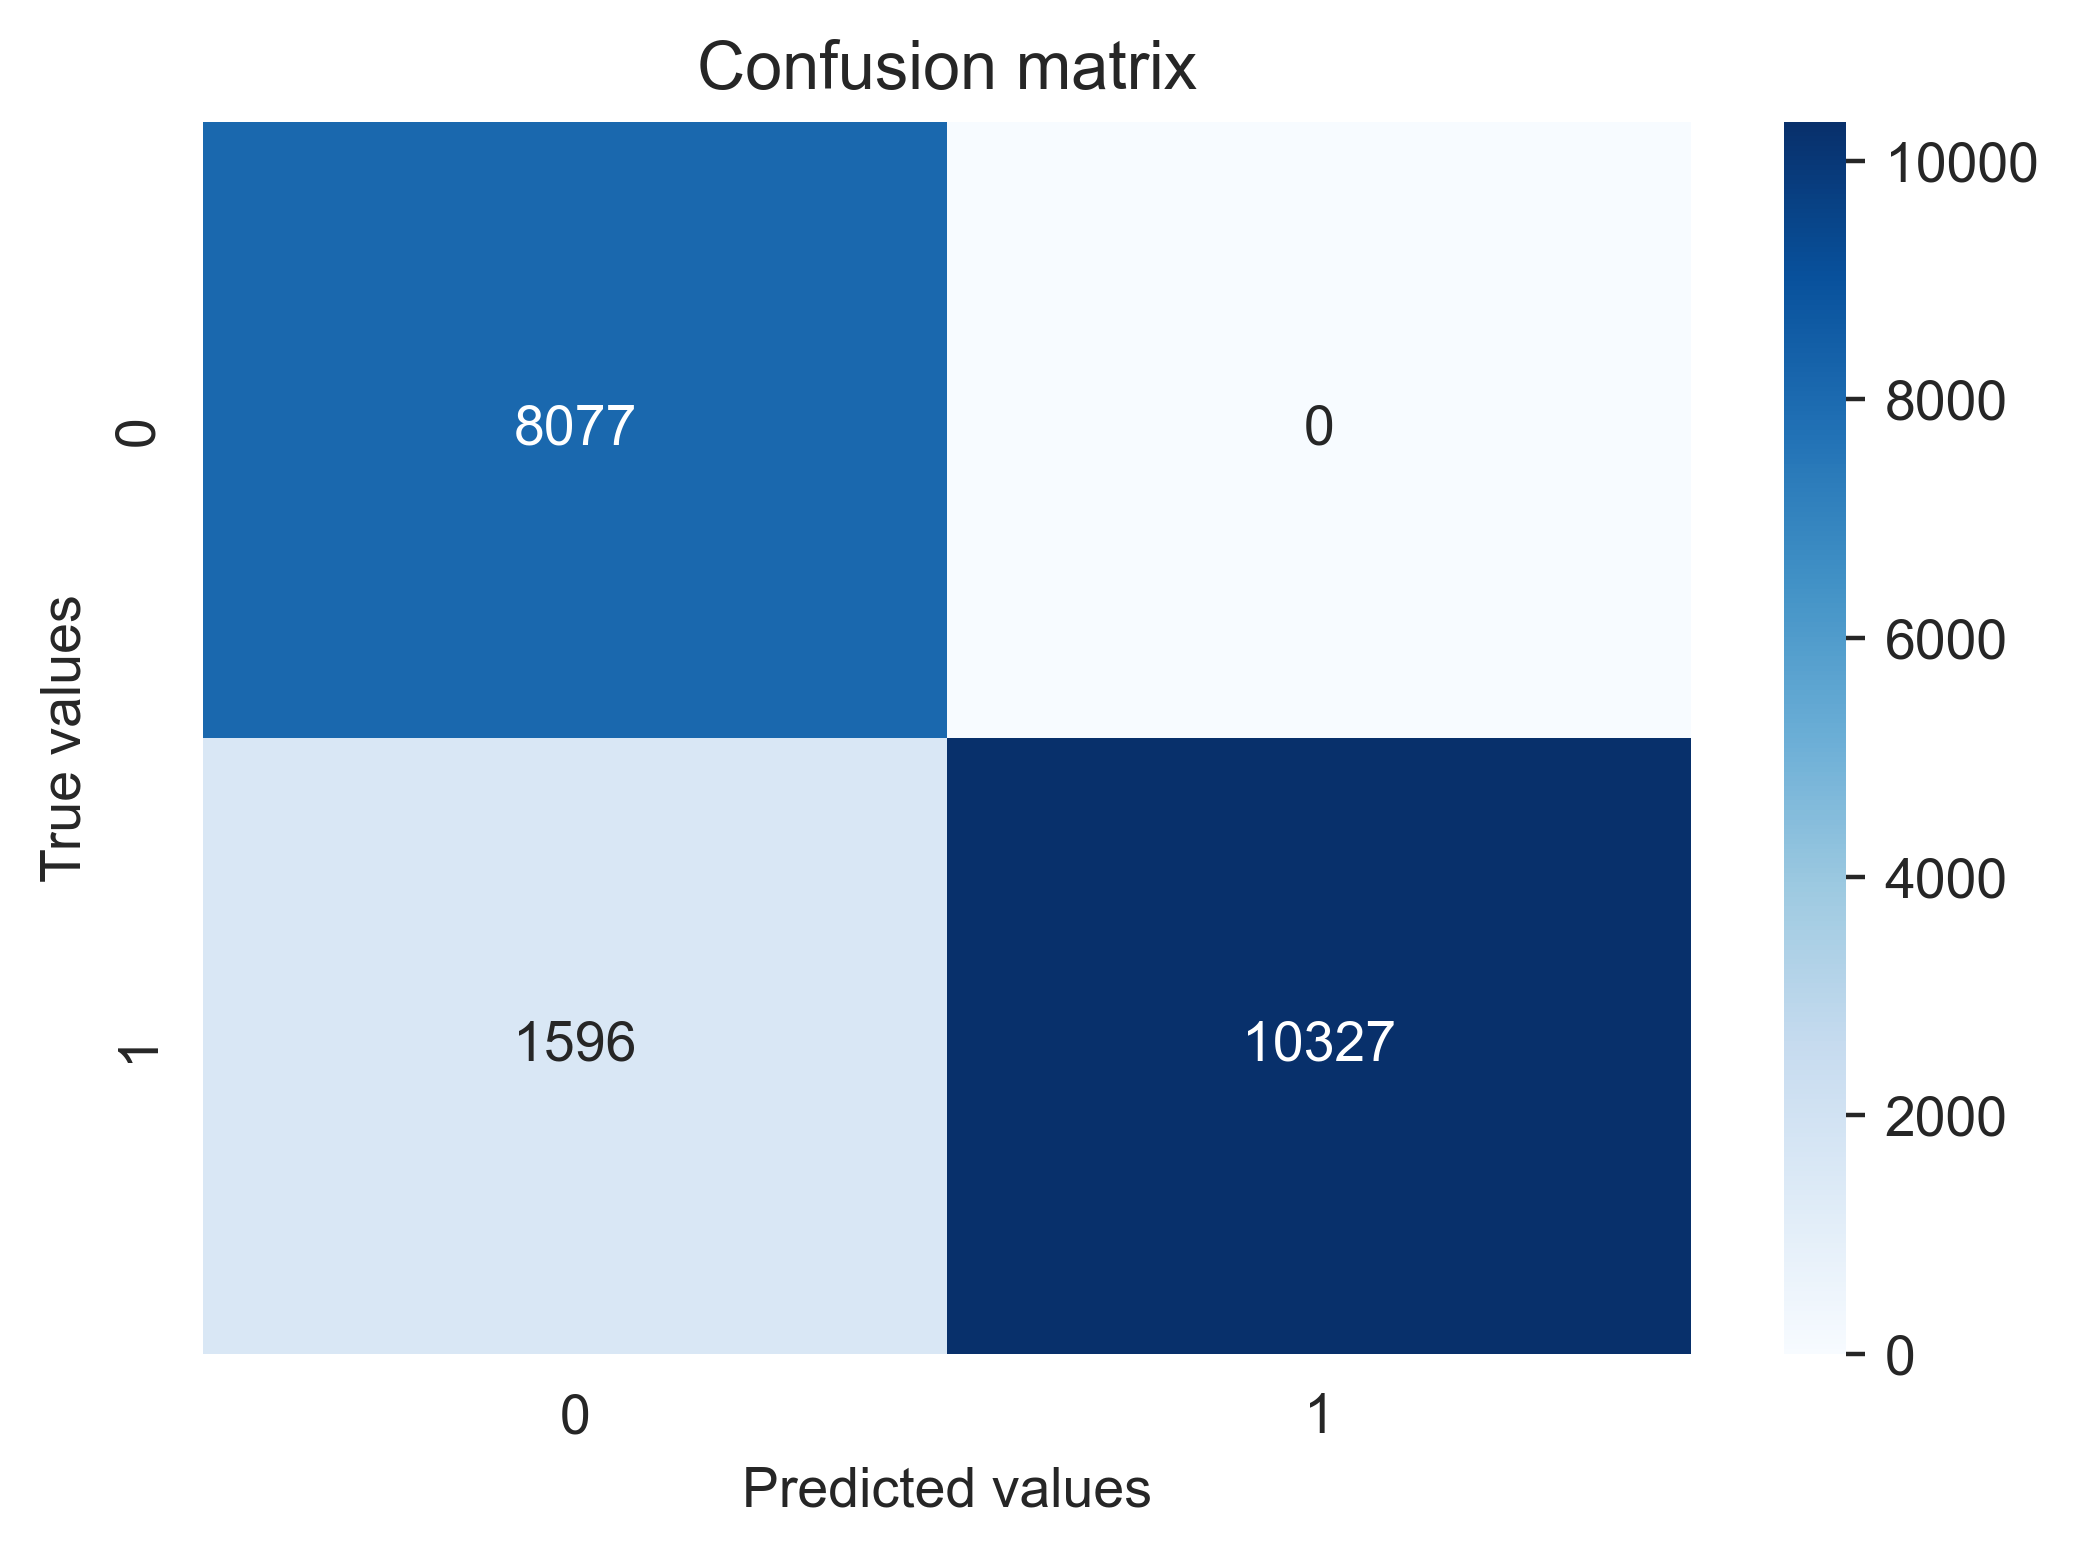

In [13]:
plt.figure(figsize=(6,4) ,dpi=400)
sns.heatmap(confusion_matrix(y_test, y_pred_lgbm), annot=True, fmt='g', cmap="Blues")
plt.xlabel('Predicted values')
plt.ylabel('True values')
plt.title('Confusion matrix')
plt.show()

In [14]:
lgbm_probs = LGBM_model.predict_proba(X_test)[:, 1]
lgbm_auc = roc_auc_score(y_test, lgbm_probs)
print(f"LGBMClassifier AUC Score: {lgbm_auc:.4f}")

LGBMClassifier AUC Score: 0.9454


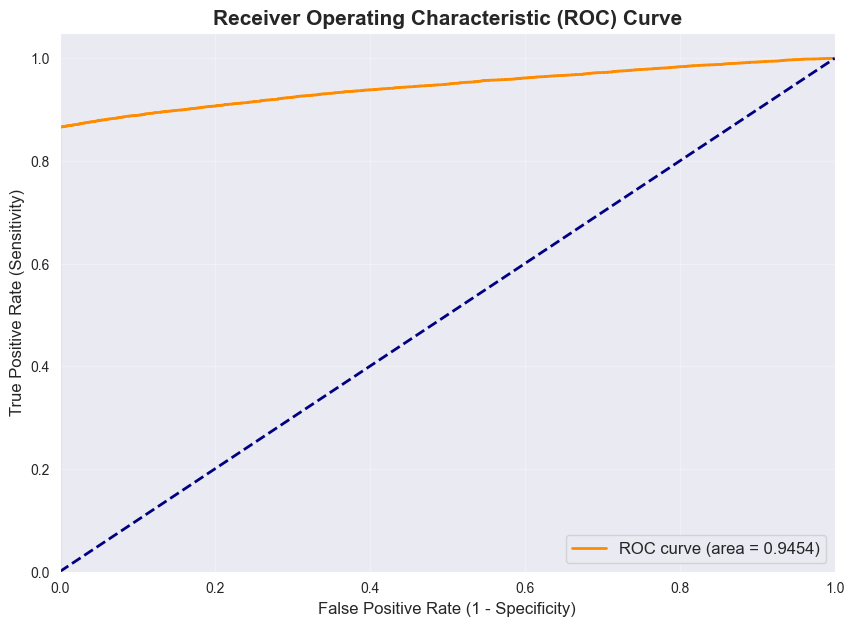

In [15]:
# 1. حساب القيم الخاصة بالكرف (False Positive Rate & True Positive Rate)
fpr, tpr, thresholds = roc_curve(y_test, lgbm_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 7), dpi=100)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity)', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=15, fontweight='bold')
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)

plt.show()

# Final Model

In [24]:
results = pd.DataFrame({
    'Model': ['XGBoost', 'LightGBM', 'LogisticRegression'],
    'AUC Score': [xgb_auc, lgbm_auc, lr_auc]
}).sort_values(by='AUC Score', ascending=False)

print(results)

                Model  AUC Score
0             XGBoost   0.945496
1            LightGBM   0.945388
2  LogisticRegression   0.932734


In [10]:
joblib.dump(XGB_model, 'XGB_model_diabetes_OriginalData.pkl')

['XGB_model_diabetes_OriginalData.pkl']